In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(20,7)})


import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

In [13]:
# Load all data
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

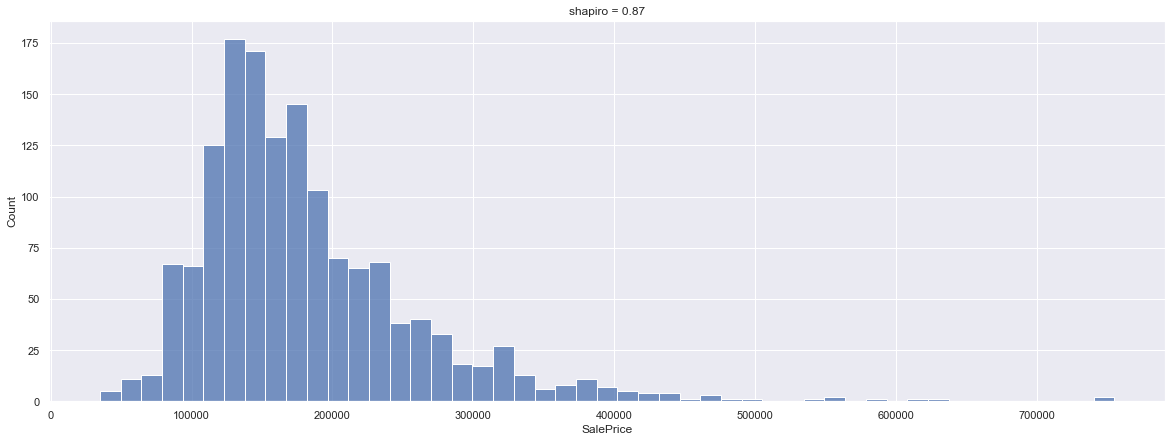

In [14]:
# SalePrice is our target feature that we want to predict
# The distribution is slightly skewed inidcating a log normal distribution

shap1 = np.round(stats.shapiro(train['SalePrice'])[0],3)

sns.histplot(train['SalePrice'], color='b')
plt.title('shapiro = {}'.format(shap1))

plt.show()

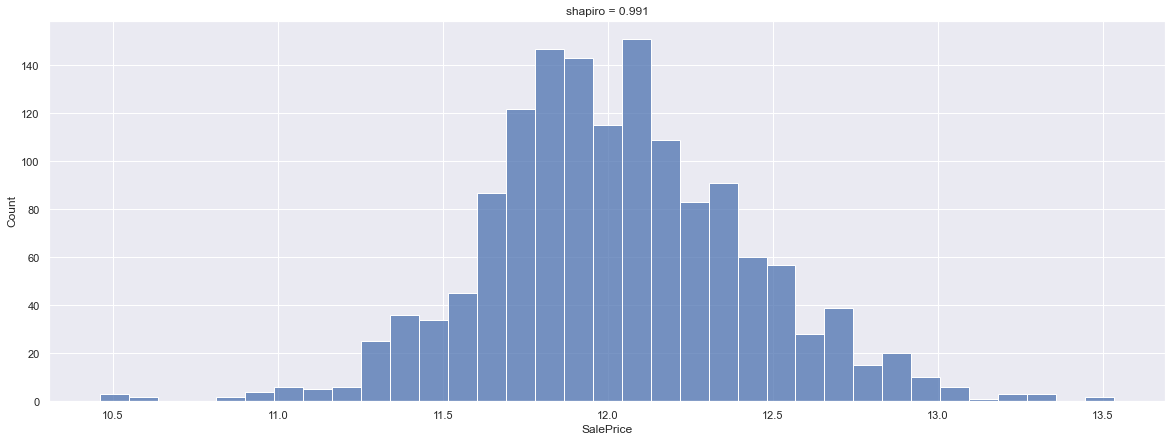

In [15]:
shap2 = np.round(stats.shapiro(np.log(train['SalePrice']))[0],3)

sns.histplot(np.log(train['SalePrice']), color='b')
plt.title('shapiro = {}'.format(shap2))

plt.show()

<AxesSubplot:>

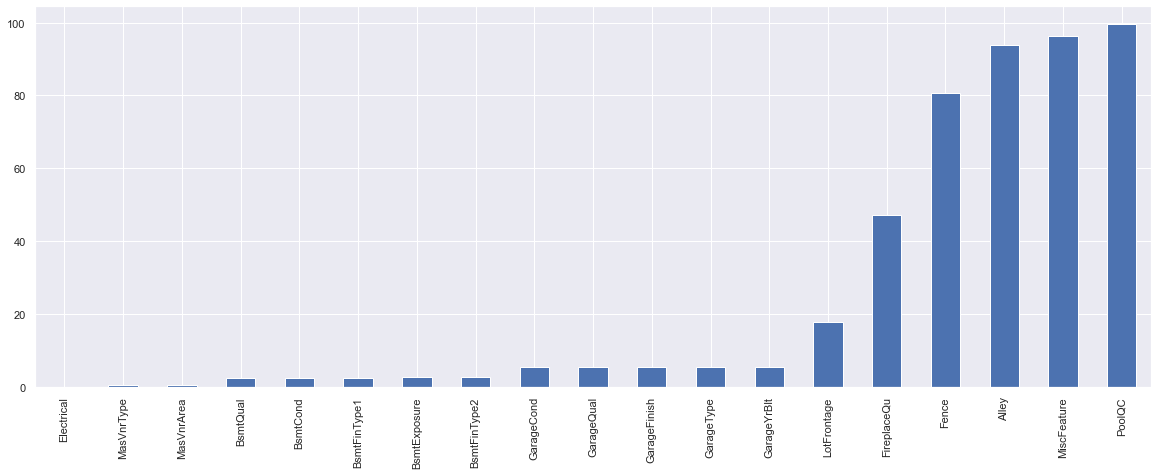

In [16]:
# lets look at all missing data as a percentage
missing = train.isnull().sum()
missing = missing[missing>0]
missing = 100 * missing/len(train)
missing.sort_values(inplace=True)

missing.plot.bar()

In [17]:
# Drop all variables that are missing over 40% of the data 
train = train.drop(labels = missing[missing>30].keys(), axis=1)
test = test.drop(labels = missing[missing>30].keys(), axis=1)

In [19]:
# Turn categorial labels into strings 
catCols = [col for col in train.columns if train[col].dtype == 'O']
le = LabelEncoder()

def label_encode(df, cols):
    
    df = df.copy()
    for col in cols:
        df[col] = le.fit_transform(df[col])
        
    return df

# Encode all data
train = label_encode(train, catCols)
test = label_encode(test, catCols)

# For the rest of the nans we will just replace them all with zeros 
train = train.fillna(0)
test = test.fillna(0)

In [58]:
# Now split data into features and labels
train_X = train.drop(columns=['SalePrice'])
train_y = np.log(train['SalePrice'])

In [59]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50)

In [60]:
# We also want to split data for evaluation
train_X_s, test_X, train_y_s, test_y = train_test_split(train_X, train_y, test_size=0.33)

# Fit model
reg.fit(train_X, train_y, eval_set = [(train_X_s, train_y_s), (test_X, test_y)], verbose=100)

[0]	validation_0-rmse:8.07869	validation_1-rmse:8.07987
[100]	validation_0-rmse:0.00997	validation_1-rmse:0.00993
[200]	validation_0-rmse:0.00135	validation_1-rmse:0.00146
[264]	validation_0-rmse:0.00105	validation_1-rmse:0.00117


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [61]:
# Let's look at the feature importances
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])

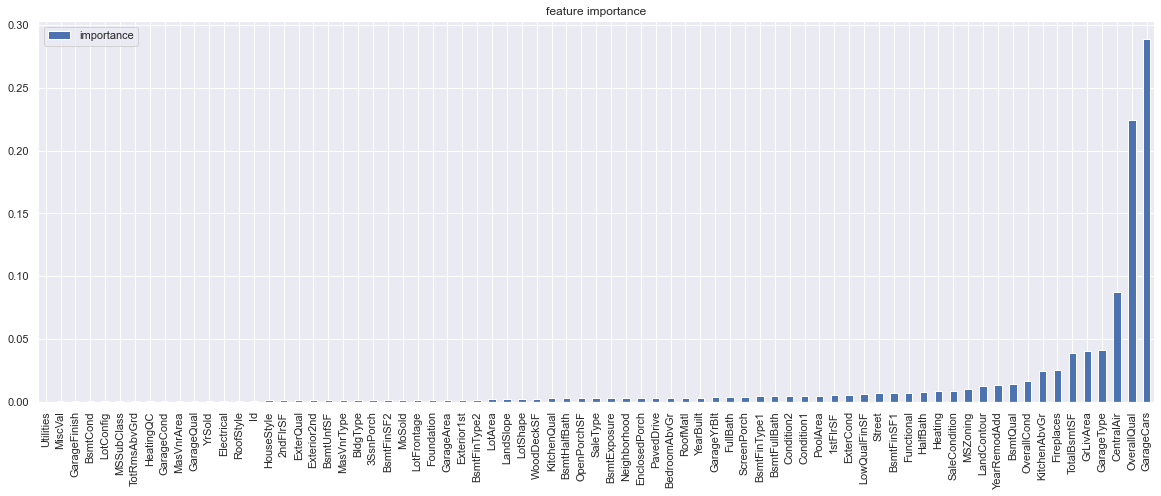

In [62]:

fi.sort_values('importance').plot(kind='bar', title='feature importance')
plt.show()

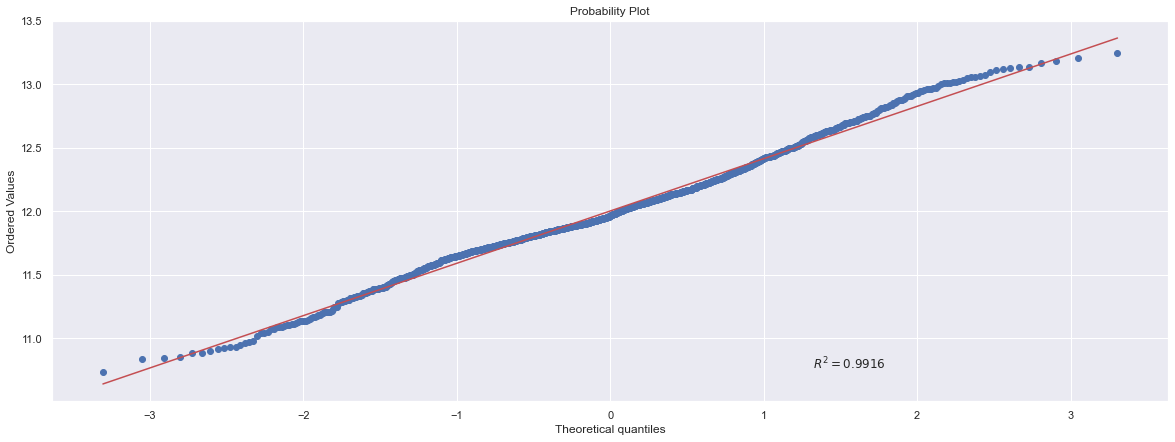

In [65]:
# Now make predictions 
test_y = reg.predict(test)

# Let's take a look this data
stats.probplot(test_y, plot=plt, rvalue=True)

plt.show()

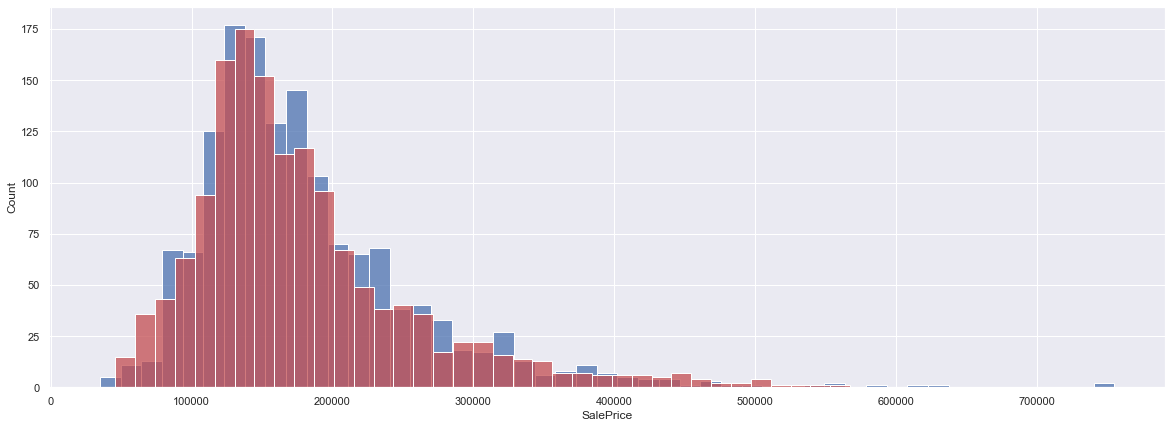

In [66]:
fig, ax = plt.subplots()

sns.histplot(np.exp(train_y), ax=ax, color='b')
sns.histplot(np.exp(test_y), ax=ax, color='r')

plt.show()

In [67]:
# Create data submission 
test['SalePrice'] = np.exp(test_y)
submission = test[['Id', 'SalePrice']]
submission.to_csv('./data/submission_xgboost.csv', index=None)